In [1]:
# File to be converted.
input_filename = 'data/0023uLRpitc_NTP_20dT_0.5GndCl.sm'
output_path = None  # Use None for saving in the same folder as the SM file

# Default configuration

In [2]:
# Used when the metadata does not contain the field identity
default_identity = dict(
    author='Weiss Lab',
    author_affiliation='UCLA',
    creator='Antonino Ingargiola',
    creator_affiliation='UCLA')

In [3]:
# Used when the metadata does not contain the field setup
default_setup = dict(
    num_pixels = 2,
    num_spots = 1,
    num_spectral_ch = 2,
    num_polarization_ch = 1,
    num_split_ch = 1,
    modulated_excitation = True,
    lifetime = False,
    excitation_cw = [True, True],
    excitation_alternated=[True, True],
    excitation_wavelengths=[532e-9, 635e-9],
    detection_wavelengths=[580e-9, 660e-9]
)

In [4]:
# Used when the metadata does not contain the field measurement_specs
def_measurement_specs = dict(
    measurement_type = 'smFRET-usALEX',
    alex_period = 4000,
    alex_offset = 700,
    alex_excitation_period1 = (2180, 3900),
    alex_excitation_period2 = (200, 1800),
    detectors_specs = dict(spectral_ch1 = [0],
                           spectral_ch2 = [1]))

# Imports

In [5]:
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

import sys
sys.path.append("../../phconvert")
import phconvert as phc
print('phconvert version: ' + phc.__version__)
%matplotlib inline

phconvert version: 0.9+43.g3a86e58.dirty


# Resolve paths

In [6]:
input_filename = Path(input_filename)
input_filename

PosixPath('data/0023uLRpitc_NTP_20dT_0.5GndCl.sm')

In [7]:
assert input_filename.is_file(), 'Input SM file not found. Check the file name.'

In [8]:
if output_path is None:
    output_path = input_filename.parent

In [9]:
out_filename = Path(output_path, input_filename.stem + '.hdf5')
out_filename

PosixPath('data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5')

In [10]:
# Create the output data folder if necessary
#out_filename.parent.mkdir(parents=True, exist_ok=True)

# Load metadata

In [11]:
meta_filename = input_filename.with_suffix('.yml')
assert meta_filename.is_file(), 'Metadata YAML file not found.'

In [12]:
with open(str(meta_filename)) as f:
    metadata = yaml.load(f)
metadata

/Users/yi10/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'sample': {'sample_name': '20dt ssDNA oligo doubly labeled with Cy3B and Atto647N',
  'dye_names': 'Cy3B, ATTO647N',
  'buffer_name': 'TE50 + 0.5M GndCl'},
 'description': 'us-ALEX measurement of a doubly-labeled ssDNA sample.\n'}

# Preprocess timestamps

In [13]:
def update_with_defaults(input_dict, default_dict):
    for k in default_dict:
        if k not in input_dict:
            input_dict[k] = default_dict[k]
    return input_dict
            

def sm_load_photon_data(filename, metadata, def_measurement_specs):
    """Load photon_data from a .sm us-ALEX file into a metadata dict.
    """
    metadata = metadata.copy()
    timestamps, detectors, labels = phc.smreader.load_sm(str(filename),
                                                         return_labels=True)
    measurement_specs = metadata.pop('measurement_specs', def_measurement_specs)
    update_with_defaults(measurement_specs, def_measurement_specs)
            
    photon_data = dict(
        timestamps = timestamps,
        timestamps_specs = dict(timestamps_unit=12.5e-9),
        detectors = detectors,
        measurement_specs = measurement_specs)

    acquisition_duration = (timestamps[-1] - timestamps[0]) * 12.5e-9
    
    provenance = dict(
        filename=str(filename), 
        software='LabVIEW Data Acquisition usALEX')
    
    metadata.update(
        _filename = str(filename),
        acquisition_duration = round(acquisition_duration),
        photon_data = photon_data,
        provenance = provenance)
    return metadata


def fill_with_defaults(metadata, default_setup, default_identity):
    """Fill all missing values in metadata with defaults."""
    setup = metadata.get('setup', default_setup)
    metadata['setup'] = update_with_defaults(setup, default_setup)

    identity = metadata.get('identity', default_identity)
    metadata['identity'] = update_with_defaults(identity, default_identity)    
    
    sample = metadata['sample']
    sample['num_dyes'] = len(sample['dye_names'].split(','))

In [14]:
data = sm_load_photon_data(input_filename, metadata, def_measurement_specs)
fill_with_defaults(data, default_setup, default_identity)

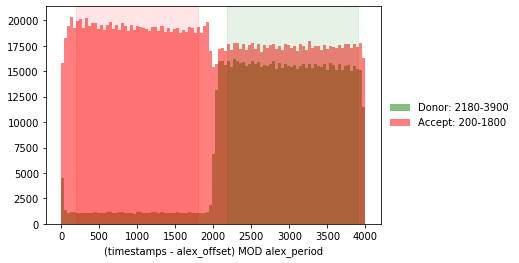

In [15]:
phc.plotter.alternation_hist(data)

# Create Photon-HDF5

In [16]:
phc.hdf5.save_photon_hdf5(data, h5_fname=str(out_filename), overwrite=True, close=True)

Saving: data/0023uLRpitc_NTP_20dT_0.5GndCl.hdf5
